# GAN Development - Kochems Approach


## Import libraries

In [34]:
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import MinMaxScaler
import io
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import csv
from collections import defaultdict
from data_reader import DataReader
from torch.autograd import Variable, grad
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import plotly.figure_factory as ff
import kaleido


np.set_printoptions(threshold=np.inf)
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


## Read in Data

### Functions to preprocess data

In [3]:
def convert_ask_bid_int(dataset):
    mask_ask = np.char.endswith(dataset[:,:,2], 'ask')
    mask_bid = np.char.endswith(dataset[:,:,2], 'bid')
    dataset[:,:,2][mask_ask] = '1'
    dataset[:,:,2][mask_bid] = '0'
    dataset = dataset.astype(np.float32)
    return dataset
    
    
def get_dataset_max_price(dataset, rows_per_orderbook, level = -1):
    index_on_each_OB = 0
    if level != -1:
        index_on_each_OB = (rows_per_orderbook//2-(level))
    last_row_prices = dataset[:, index_on_each_OB, 0]
    max_val = np.max(last_row_prices)
    return max_val

def get_dataset_min_price(dataset, rows_per_orderbook, level = -1):
    index_on_each_OB = -1
    if level != -1:
        index_on_each_OB = (rows_per_orderbook//2+(level-1))
    first_row_prices = dataset[:, index_on_each_OB, 0]
    min_val = np.min(first_row_prices)
    return min_val

def make_histogram_from_dataset(dataset, rows_per_orderbook = 100, bin_width = 0.5, level = -1):
    X_train = []
    hist_max = get_dataset_max_price(dataset, rows_per_orderbook, level)
    hist_min = get_dataset_min_price(dataset, rows_per_orderbook, level)
    print("range: ", hist_min, " ", hist_max)
    num_bins = int(np.ceil((hist_max-hist_min) / bin_width))
    bins = np.linspace(hist_min, hist_max, num_bins)
    for i in range(len(dataset)):
        orderbook = dataset[i]
        price = orderbook[:,0]
        quantity = orderbook[:,1]
        quantity[orderbook[:, 2] == 0] *= -1
        hist, bin_edges = np.histogram(price, bins=bins, weights=quantity)
        X_train.append(hist)
    X_train = np.array(X_train)
    return X_train, hist_min, hist_max, bins

def make_centred_LOB_snapshots(histograms, level = 1):
    X_train = []
    y_train = []
    for i in range(len(histograms)-1):
        current_OB = histograms[i]
        next_OB = histograms[i+1]
        j = -1
        while j < len(current_OB)-1 and not (current_OB[j] < 0 and current_OB[j+1] > 0): j+=1
        j+=1
        
        current_start_index = j-level
        current_subarray_size = 2 * level
        current_centre_LOB_snapshot = current_OB[current_start_index: current_start_index + current_subarray_size]
        
        next_subarray_size = 2 * current_subarray_size
        next_centre_LOB_snapshot = next_OB[current_start_index - level: (current_start_index - level) + next_subarray_size]
        
        if np.any(next_centre_LOB_snapshot == 0):
            continue
        
        X_train.append(current_centre_LOB_snapshot)
        y_train.append(next_centre_LOB_snapshot)
    
    X_train = np.vstack(X_train)
    y_train = np.vstack(y_train)
    
    return X_train, y_train
        
def normalization(X_train, c=8):
    sqrt_abs_over_c = np.sqrt(np.abs(X_train)) / c
    with_sign = np.sign(X_train) * sqrt_abs_over_c
    return with_sign

def get_centre_of_LOB(X_t_delta_t, level=3):
    index = -1
    for i in range(len(X_t_delta_t)-1):
        if X_t_delta_t[i] < 0 and X_t_delta_t[i+1]>0: index = i+1
    return X_t_delta_t[(index-level): (index-level) + 2 * level]

def get_centre_of_LOB_dataset(X_t_delta_t_dataset, level = 3):
    centres = []
    for i in range(len(X_t_delta_t_dataset)):
        if np.any(X_t_delta_t_dataset[i] == 0): continue
        centre = get_centre_of_LOB(X_t_delta_t_dataset[i], level)
        if centre.size != 6: continue
        centres.append(centre)
    np.array(centres)
    return centres
            

### Functions to post-process data

In [4]:
def reverse_normalization(X_train_normalized, c=8):
    if not isinstance(X_train_normalized, np.ndarray) and X_train_normalized.device.type == 'cuda':
        X_train_normalized = X_train_normalized.cpu()
    unscaled_data = X_train_normalized * c
    X_train = np.sign(X_train_normalized) * (unscaled_data ** 2)
    return X_train
    

### Functions to graph

In [5]:
def draw_avg_centre_comparison(X_t_delta_t_generated_dataset, real_dataset, level = 3):
    generated_dataset_centres = get_centre_of_LOB_dataset(X_t_delta_t_generated_dataset, level)
    mean_real = np.mean(real_dataset, axis=0)
    mean_fake = np.mean(generated_dataset_centres, axis=0)
    interleaved_array = np.empty(mean_real.size + mean_fake.size, dtype=mean_real.dtype)
    interleaved_array[0::2] = mean_real
    interleaved_array[1::2] = mean_fake
    indices = np.arange(len(interleaved_array))
    return indices, interleaved_array

### Actually reading in data

In [6]:
data_reader = DataReader("./orderbook_snapshots.csv", rows_per_orderbook=100)
data_reader.read_csv()
X_train_raw = data_reader.get_data()
X_train_raw = convert_ask_bid_int(X_train_raw)
print(X_train_raw.shape)

(78252, 100, 3)


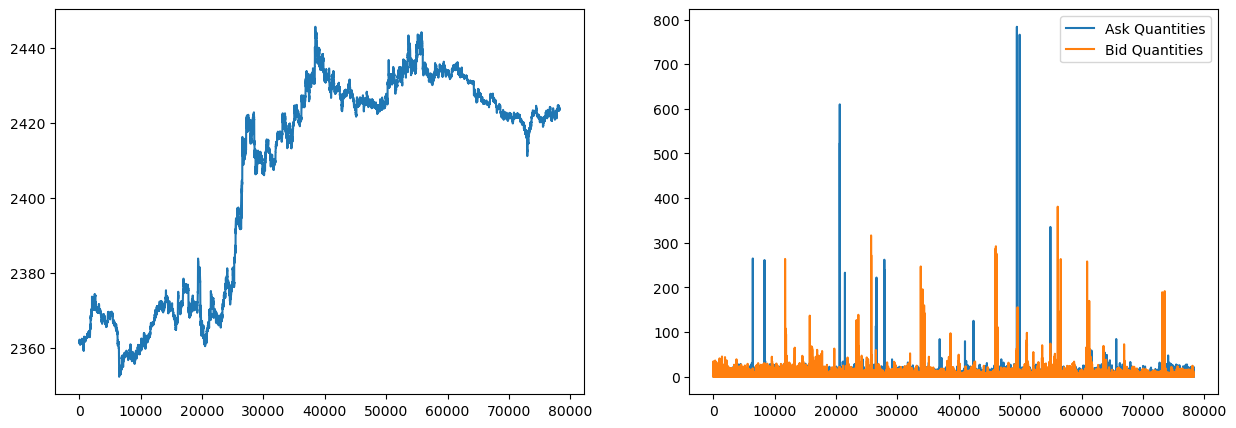

In [7]:
best_prices = (X_train_raw[:, 49, 0] + X_train_raw[:, 50, 0]) /2
best_ask_quantities = X_train_raw[:, 49, 1]
best_bid_quantities = np.abs(X_train_raw[:, 50, 1])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(best_prices, label='Prices')
axes[1].plot(best_ask_quantities, label='Ask Quantities')
axes[1].plot(best_bid_quantities, label='Bid Quantities')
plt.legend()
plt.show()

### Preprocess data

In [8]:
histograms, price_min, price_max, bins = make_histogram_from_dataset(X_train_raw, rows_per_orderbook=100, bin_width=0.5, level=-1)
print(histograms.shape)
print(bins)

range:  2346.7   2452.7
(78252, 211)
[2346.69995117 2347.20232084 2347.70469051 2348.20706018 2348.70942984
 2349.21179951 2349.71416918 2350.21653885 2350.71890852 2351.22127819
 2351.72364785 2352.22601752 2352.72838719 2353.23075686 2353.73312653
 2354.2354962  2354.73786586 2355.24023553 2355.7426052  2356.24497487
 2356.74734454 2357.24971421 2357.75208387 2358.25445354 2358.75682321
 2359.25919288 2359.76156255 2360.26393221 2360.76630188 2361.26867155
 2361.77104122 2362.27341089 2362.77578056 2363.27815022 2363.78051989
 2364.28288956 2364.78525923 2365.2876289  2365.78999857 2366.29236823
 2366.7947379  2367.29710757 2367.79947724 2368.30184691 2368.80421657
 2369.30658624 2369.80895591 2370.31132558 2370.81369525 2371.31606492
 2371.81843458 2372.32080425 2372.82317392 2373.32554359 2373.82791326
 2374.33028293 2374.83265259 2375.33502226 2375.83739193 2376.3397616
 2376.84213127 2377.34450093 2377.8468706  2378.34924027 2378.85160994
 2379.35397961 2379.85634928 2380.3587189

### Non-Marginal Histogram of all Orderbook States

(78138, 6)   (78138, 12)
[-38.811523 -50.756104 -27.78772   25.371094  94.59961  256.45312 ]
[-208.55713   -87.99841  -166.2403    -44.319336  -47.312866  -24.945312
   23.384766   86.31836   256.45312    70.82385   156.65088    72.88672 ]


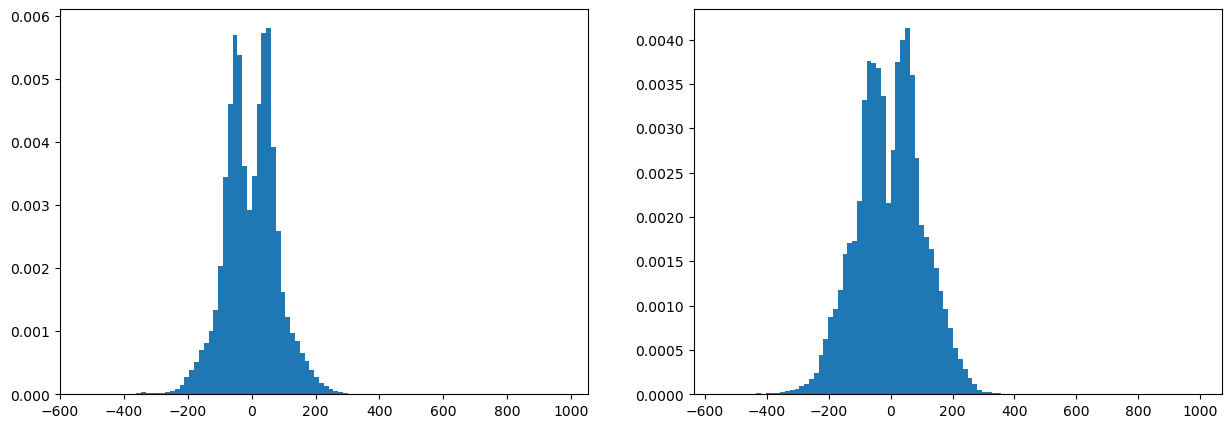

(78138, 6)   (78138, 12)
[-0.7787362  -0.8905415  -0.6589257   0.62962157  1.2157792   2.0017693 ]
[-1.8051884  -1.1725934  -1.6116775  -0.83215964 -0.85980433 -0.62431604
  0.60447246  1.161346    2.0017693   1.0519613   1.5645031   1.0671715 ]


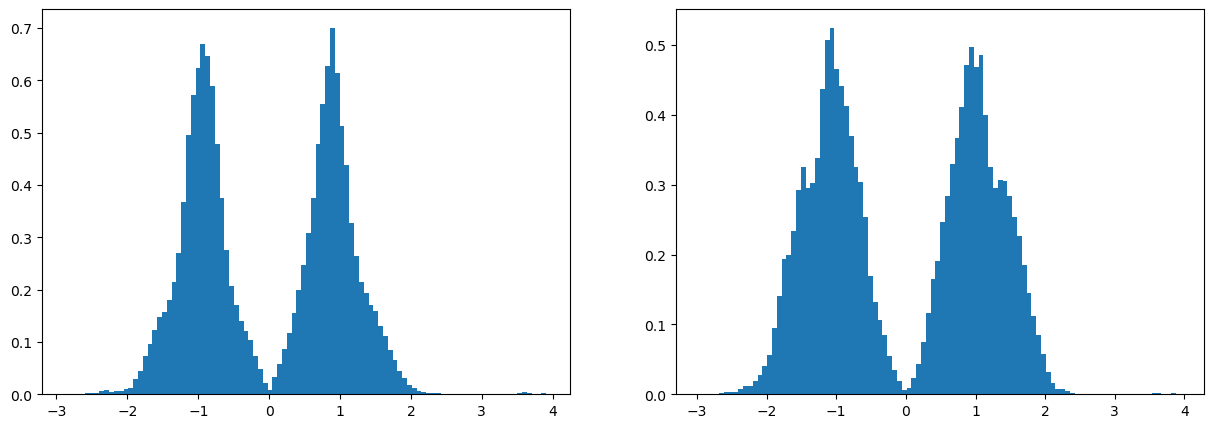

In [9]:
X_train_not_processed, y_train_not_processed = make_centred_LOB_snapshots(histograms, level=3)
print(X_train_not_processed.shape," ",y_train_not_processed.shape)
print(X_train_not_processed[0])
print(y_train_not_processed[0])
all_orders = X_train_not_processed.ravel()
all_orders_next = y_train_not_processed.ravel()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(all_orders, bins=100, density=True)
axes[1].hist(all_orders_next, bins=100, density=True)

plt.show()

S_t_dataset = normalization(X_train=X_train_not_processed,c=8)
X_t_delta_t_dataset = normalization(X_train=y_train_not_processed,c=8)
print(S_t_dataset.shape," ", X_t_delta_t_dataset.shape)
print(S_t_dataset[0])
print(X_t_delta_t_dataset[0])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(S_t_dataset.ravel(), bins=100, density=True)
axes[1].hist(X_t_delta_t_dataset.ravel(), bins=100, density=True)

plt.show()

### Marginal Distributions (Normalized)

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ve

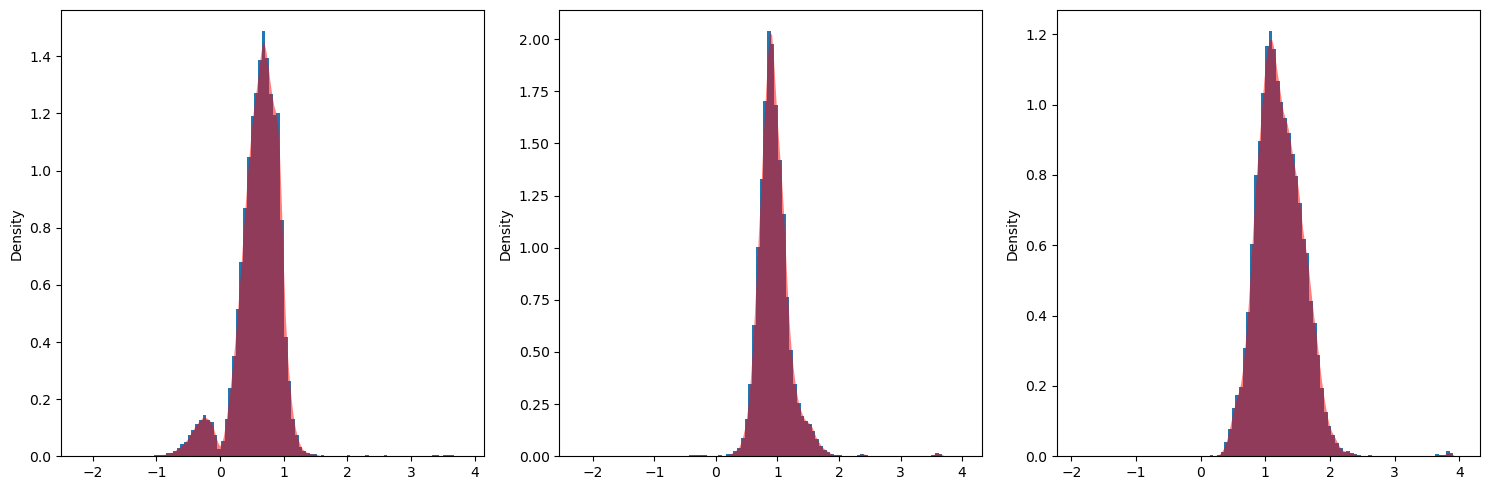

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ve

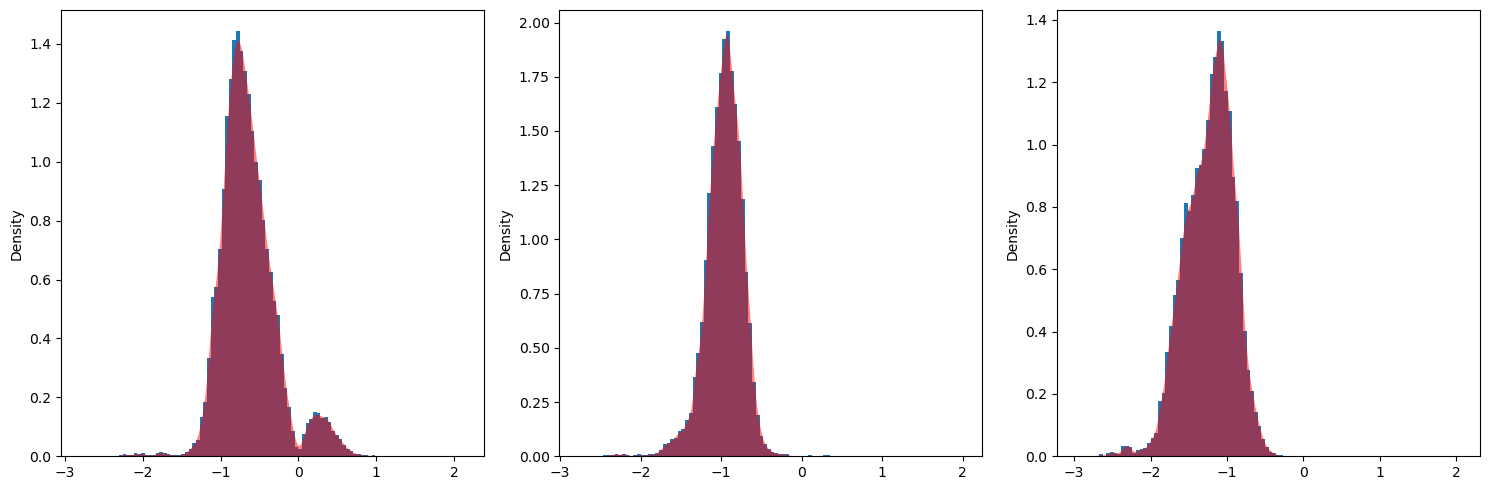

In [18]:
# asks_1 = X_t_delta_t_dataset[:, 6]
# asks_2 = X_t_delta_t_dataset[:, 7]
# asks_3 = X_t_delta_t_dataset[:, 8]

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# axes[0].hist(asks_1, bins=100, density=True)
# sns.kdeplot(asks_1, ax=axes[0], color='red', fill=True, linewidth=0, alpha=0.5)
# axes[1].hist(asks_2, bins=100, density=True)
# sns.kdeplot(asks_2, ax=axes[1], color='red', fill=True, linewidth=0, alpha=0.5)
# axes[2].hist(asks_3, bins=100, density=True)
# sns.kdeplot(asks_3, ax=axes[2], color='red', fill=True, linewidth=0, alpha=0.5)

# plt.tight_layout()
# plt.show()

# bids_1 = X_t_delta_t_dataset[:, 5]
# bids_2 = X_t_delta_t_dataset[:, 4]
# bids_3 = X_t_delta_t_dataset[:, 3]

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# axes[0].hist(bids_1, bins=100, density=True)
# sns.kdeplot(bids_1, ax=axes[0], color='red', fill=True, linewidth=0, alpha=0.5)
# axes[1].hist(bids_2, bins=100, density=True)
# sns.kdeplot(bids_2, ax=axes[1], color='red', fill=True, linewidth=0, alpha=0.5)
# axes[2].hist(bids_3, bins=100, density=True)
# sns.kdeplot(bids_3, ax=axes[2], color='red', fill=True, linewidth=0, alpha=0.5)

# plt.tight_layout()
# plt.show()



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace inf and -inf with NaN in your dataset columns
X_t_delta_t_dataset = np.where(np.isinf(X_t_delta_t_dataset), np.nan, X_t_delta_t_dataset)

# Assuming you've defined X_t_delta_t_dataset
asks_1 = X_t_delta_t_dataset[:, 6].astype(float)
asks_2 = X_t_delta_t_dataset[:, 7].astype(float)
asks_3 = X_t_delta_t_dataset[:, 8].astype(float)

# Remove or handle NaN values if necessary
# For example, drop NaN values for plotting
asks_1 = asks_1[~np.isnan(asks_1)]
asks_2 = asks_2[~np.isnan(asks_2)]
asks_3 = asks_3[~np.isnan(asks_3)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(asks_1, bins=100, density=True)
sns.kdeplot(asks_1, ax=axes[0], color='red', fill=True, linewidth=0, alpha=0.5)
axes[1].hist(asks_2, bins=100, density=True)
sns.kdeplot(asks_2, ax=axes[1], color='red', fill=True, linewidth=0, alpha=0.5)
axes[2].hist(asks_3, bins=100, density=True)
sns.kdeplot(asks_3, ax=axes[2], color='red', fill=True, linewidth=0, alpha=0.5)

plt.tight_layout()
plt.show()

# Repeat the process for bids
bids_1 = X_t_delta_t_dataset[:, 5].astype(float)
bids_2 = X_t_delta_t_dataset[:, 4].astype(float)
bids_3 = X_t_delta_t_dataset[:, 3].astype(float)

# Remove or handle NaN values if necessary
bids_1 = bids_1[~np.isnan(bids_1)]
bids_2 = bids_2[~np.isnan(bids_2)]
bids_3 = bids_3[~np.isnan(bids_3)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(bids_1, bins=100, density=True)
sns.kdeplot(bids_1, ax=axes[0], color='red', fill=True, linewidth=0, alpha=0.5)
axes[1].hist(bids_2, bins=100, density=True)
sns.kdeplot(bids_2, ax=axes[1], color='red', fill=True, linewidth=0, alpha=0.5)
axes[2].hist(bids_3, bins=100, density=True)
sns.kdeplot(bids_3, ax=axes[2], color='red', fill=True, linewidth=0, alpha=0.5)

plt.tight_layout()
plt.show()



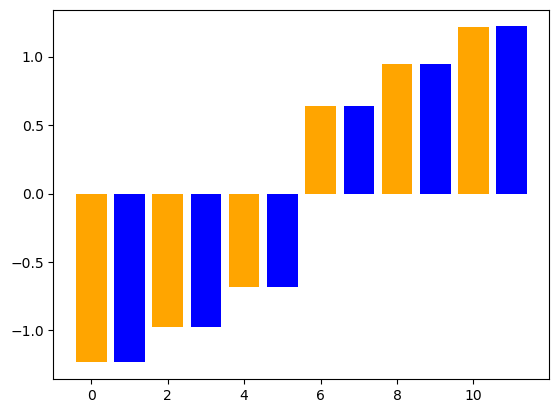

In [19]:
indices, interleaved_array = draw_avg_centre_comparison(X_t_delta_t_dataset, S_t_dataset, level = 3)
plt.bar(indices, interleaved_array, color=['orange', 'blue'] * (len(interleaved_array) // 2))
plt.show()

In [20]:
S_t_dataset_tensor = torch.tensor(S_t_dataset, dtype=torch.float32).to(device)
X_t_delta_t_dataset_tensor = torch.tensor(X_t_delta_t_dataset, dtype=torch.float32).to(device)
dataset = TensorDataset(X_t_delta_t_dataset_tensor, S_t_dataset_tensor)
data_loader = DataLoader(dataset, batch_size=500, shuffle=True)

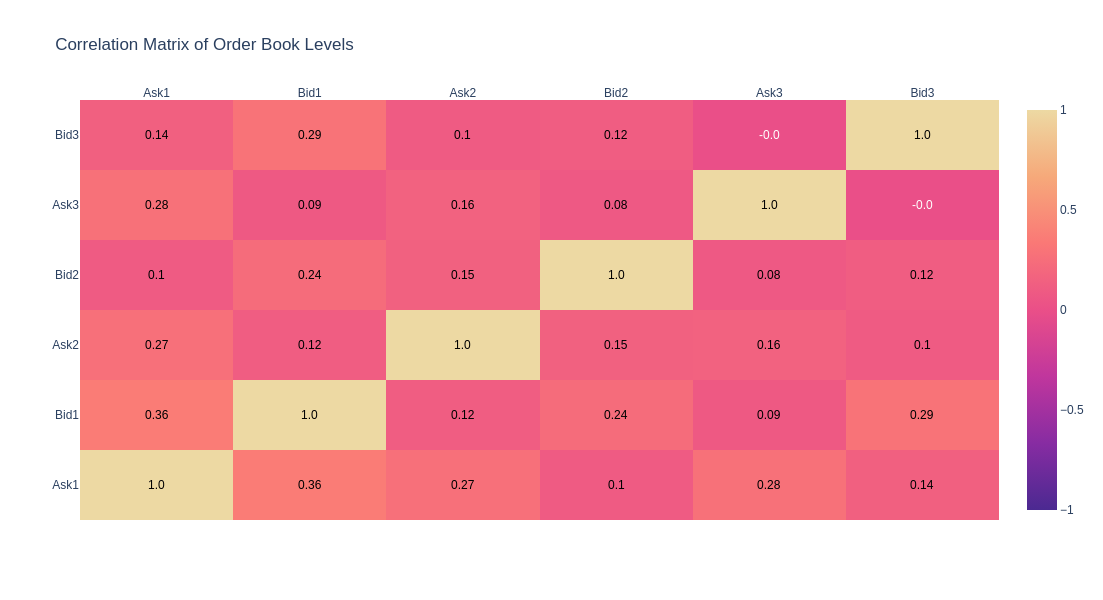

In [37]:
# import numpy as np
# import pandas as pd

# # First, select the relevant slices of the array for bid_1, bid_2, bid_3, ask_1, ask_2, and ask_3
# data = X_t_delta_t_dataset[:, [6, 5, 7, 4, 8, 3]]

# # Convert this data into a pandas DataFrame
# columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
# df = pd.DataFrame(data, columns=columns)
# df.dropna(inplace=True)     # Example: Drop rows with NaNs

# # Compute the correlation matrix
# correlation_matrix = df.corr()

# # Plotting the correlation matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True, vmin=-1, vmax=1)
# plt.title('Correlation Matrix of Order Book Levels')
# plt.show()


# Assuming X_t_delta_t_dataset is correctly defined earlier in your script
data = X_t_delta_t_dataset[:, [6, 5, 7, 4, 8, 3]]

# Convert this data into a pandas DataFrame
columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
df = pd.DataFrame(data, columns=columns)

# Ensure data types are numeric for correlation computation
df = df.apply(pd.to_numeric, errors='coerce')

# Compute the correlation matrix
correlation_matrix = df.corr()

# Reverse the order of rows in 'z' and 'annotation_text', and reverse the y-axis labels
z_reversed = correlation_matrix.to_numpy()[::-1]
annotation_text_reversed = correlation_matrix.round(2).to_numpy()[::-1]
y_reversed = correlation_matrix.columns.tolist()[::-1]

# Generate the heatmap
fig = ff.create_annotated_heatmap(
    z=correlation_matrix.to_numpy(),
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.columns.tolist(),
    annotation_text=correlation_matrix.round(2).to_numpy(),
    colorscale='agsunset',
    showscale=True,
    zmin=-1, # Set minimum of scale
    zmax=1  # Set maximum of scale
)

# Update layout to make it more readable
fig.update_layout(
    title='Correlation Matrix of Order Book Levels',
    xaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
    yaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
    width=600, 
    height=600,
)

fig.show()

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ve

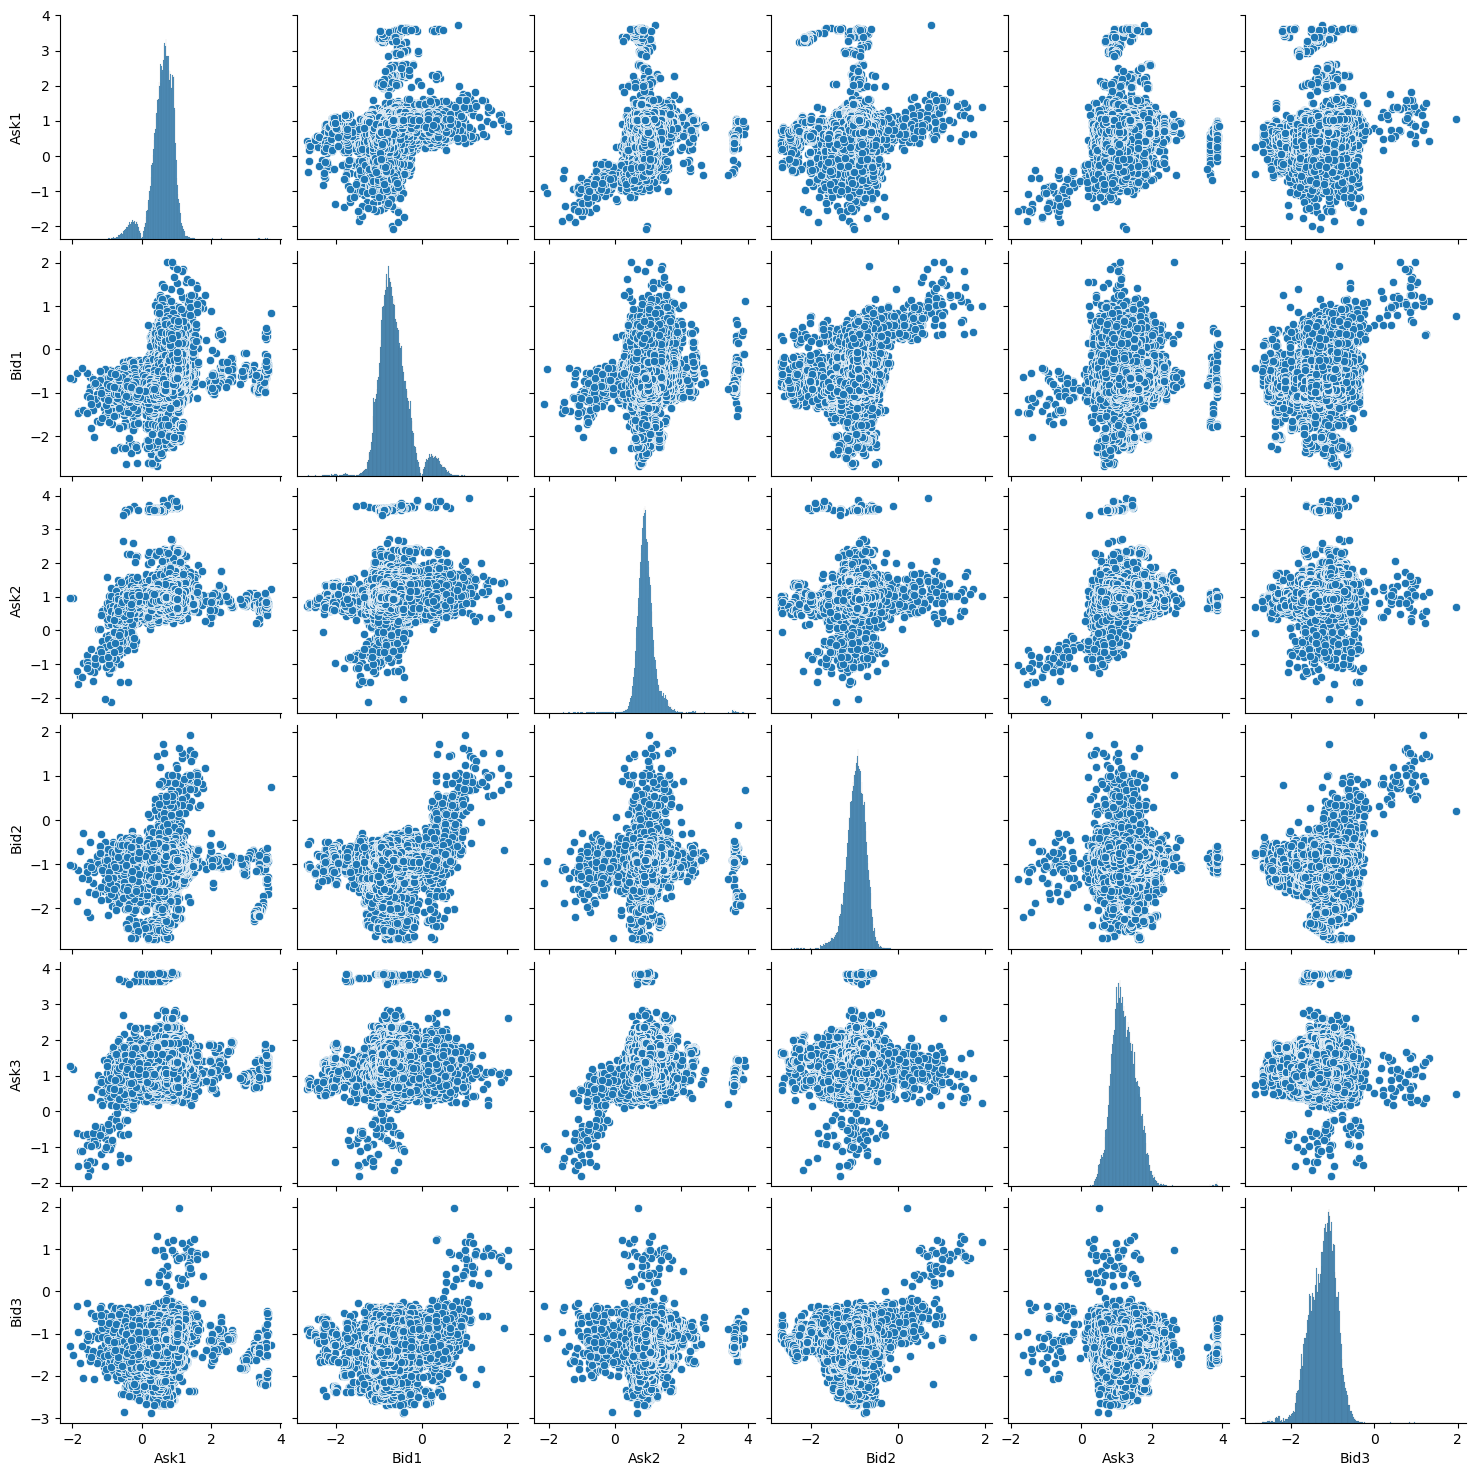

In [14]:
# First, select the relevant slices of the array for bid_1, bid_2, bid_3, ask_1, ask_2, and ask_3
data = X_t_delta_t_dataset[:, [6, 5, 7, 4, 8, 3]]

# Convert this data into a pandas DataFrame
columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
df = pd.DataFrame(data, columns=columns)

sns.pairplot(df)

## WGAN-GP Training

### Defining the Critic and Generator

In [41]:
class Generator(nn.Module):
    def __init__(self, latent_dim=6, n=6):
        super(Generator, self).__init__()
        self.h_11 = nn.Linear(latent_dim,32).to(device)
        self.h_12 = nn.Linear(n,32).to(device)
        self.h_21 = nn.Linear(32,32).to(device)
        self.h_22 = nn.Linear(32,32).to(device)
        self.h_32 = nn.Linear(64, 64).to(device)
        self.h_33 = nn.Linear(64, 12).to(device)
        self.h_34 = nn.Linear(6, 6).to(device)

    def forward(self, Z_t, S_t):
        Z_t = Z_t.to(device)  # Move input tensor to the device
        S_t = S_t.to(device)  # Move input tensor to the device

        h_11_output = torch.relu(self.h_11(Z_t))
        h_21_output = torch.relu(self.h_21(h_11_output))
        
        h_12_output = torch.relu(self.h_12(S_t))
        h_22_output = torch.relu(self.h_22(h_12_output))
        
        # Concatenation
        h_31_output = torch.cat((h_21_output, h_22_output), dim=1)
        
        h_32_output = torch.relu(self.h_32(h_31_output))
        h_33_output = self.h_33(h_32_output)

        h_34_output = torch.relu(self.h_34(h_33_output[:, 3: 9]))
        concatenated_output = torch.cat((h_33_output[:,:3], h_34_output, h_33_output[:, 9:]), dim=1)
        return concatenated_output

'''
# Markovian Setting
class Critic(nn.Module):
    def __init__(self, n_1=12, n_2=6):
        super(Critic, self).__init__()
        self.h_11 = nn.Linear(n_1,32).to(device)
        self.h_12 = nn.Linear(n_2,32).to(device)
        self.h_21 = nn.Linear(32,32).to(device)
        self.h_22 = nn.Linear(32,32).to(device)
        self.h_32 = nn.Linear(64, 64).to(device)
        self.h_33 = nn.Linear(64, 1).to(device)

    def forward(self, X_t_delta_t, S_t):
        X_t_delta_t = X_t_delta_t.to(device)  # Move input tensor to the device
        S_t = S_t.to(device)  # Move input tensor to the device

        h_11_output = torch.relu(self.h_11(X_t_delta_t))
        h_21_output = torch.relu(self.h_21(h_11_output))
        
        h_12_output = torch.relu(self.h_12(S_t))
        h_22_output = torch.relu(self.h_22(h_12_output))
        
        # Concatenation
        h_31_output = torch.cat((h_21_output, h_22_output), dim=1)
        
        h_32_output = torch.relu(self.h_32(h_31_output))
        h_33_output = self.h_33(h_32_output)
        return h_33_output
'''


class Critic(nn.Module):
    def __init__(self, n_1=12, n_2=6):
        super(Critic, self).__init__()
        # Increasing the depth and width of the network
        self.model = nn.Sequential(
            nn.Linear(n_1 + n_2, 64).to(device),
            nn.LeakyReLU(0.2).to(device),
            nn.Linear(64, 128).to(device),
            nn.LeakyReLU(0.2).to(device),
            nn.Linear(128, 256).to(device),
            nn.LeakyReLU(0.2).to(device),
            nn.Dropout(0.3).to(device),
            nn.Linear(256, 1).to(device)
        )

    def forward(self, X_t_delta_t, S_t):
        X_t_delta_t = X_t_delta_t.to(device)  # Move input tensor to the device
        S_t = S_t.to(device)  # Move input tensor to the device        
        # Concatenation of inputs
        combined_input = torch.cat((X_t_delta_t, S_t), dim=1)
        validity = self.model(combined_input)
        return validity


In [42]:
# Define training hyperparameters
n_critic = 5
z_t_dim = 12
LAMBDA = 10
epochs = 10000

# Instantiate the generator and discriminator with device adaptation
generator = Generator(latent_dim=z_t_dim, n=6).to(device)
critic = Critic(n_1=12, n_2=6).to(device)

# Define the optimisers
optimizer_G = optim.Adam(generator.parameters(), lr=0.00001, betas=(0, 0.9))
optimizer_D = optim.Adam(critic.parameters(), lr=0.00001, betas=(0, 0.9))

avg_d_loss_list = []
avg_g_loss_list = []

### Defining the training loop

#### Tensorboard run location

In [43]:
# Initialize SummaryWriter
writelocation = "runs/" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
writer = SummaryWriter(writelocation)
    

#### Tensorboard functions

In [44]:
def write_marginal_distributions_to_tensorboard(epoch, X_t_delta_t_generated):
    # Function to create and log a KDE plot
    def log_kde_plot(data, title, epoch, writer):
        plt.figure(figsize=(10, 6))
        plt.hist(data.cpu().numpy(), bins=100, density=True)
        sns.kdeplot(data.cpu().numpy(), color='red', fill=True, alpha=0.5)
        plt.title(title)
        # Save the plot to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close()
        buf.seek(0)
        # Use add_image to log the plot
        writer.add_image(title, plt.imread(buf), epoch, dataformats='HWC')
    # Indices for asks and bids might need adjustment based on dataset structure
    asks_bids_indices = {
        'Ask 1': 6,
        'Ask 2': 7,
        'Ask 3': 8,
        'Bid 1': 5,
        'Bid 2': 4,
        'Bid 3': 3,
    }

    for title, index in asks_bids_indices.items():
        data = X_t_delta_t_generated[:, index]
        log_kde_plot(data, title, epoch, writer)
        
        
# def write_covariance_matrix_of_generated_data_to_tensorboard(epoch, X_t_delta_t_generated):
#     best_k_ask_bids = X_t_delta_t_generated[:, [6, 5, 7, 4, 8, 3]].cpu().numpy()
#     columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
#     df = pd.DataFrame(best_k_ask_bids, columns=columns)
#     correlation_matrix = df.corr()
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True, vmin=-1, vmax=1)
#     plt.title('Correlation Matrix of Order Book Levels')
#     # Save the plot to a buffer
#     buf = io.BytesIO()
#     plt.savefig(buf, format='png')
#     plt.close()
#     buf.seek(0)
#     # Use add_image to log the plot
#     writer.add_image('Correlation Matrix of Order Book Levels', plt.imread(buf), epoch, dataformats='HWC')

def write_covariance_matrix_of_generated_data_to_tensorboard(epoch, X_t_delta_t_generated):
    data = X_t_delta_t_generated[:, [6, 5, 7, 4, 8, 3]].cpu().numpy()
    columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
    df = pd.DataFrame(data, columns=columns)
    df = df.apply(pd.to_numeric, errors='coerce')
    correlation_matrix = df.corr()

    fig = ff.create_annotated_heatmap(
        z=correlation_matrix.to_numpy(),
        x=correlation_matrix.columns.tolist(),
        y=correlation_matrix.columns.tolist()[::-1],  # Reverse y-axis labels for visual consistency
        annotation_text=correlation_matrix.round(2).to_numpy(),
        colorscale='agsunset',
        showscale=True,
        zmin=-1, 
        zmax=1
    )

    fig.update_layout(
        title='Correlation Matrix of Order Book Levels',
        xaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns),
        yaxis=dict(tickmode='array', tickvals=np.arange(len(columns)), ticktext=columns[::-1]),  # Ensure y-axis is reversed
        width=600, 
        height=600,
    )

    # Convert Plotly fig to PNG image using kaleido
    img_bytes = fig.to_image(format="png")

    # Use io.BytesIO as an in-memory file to read the image
    buf = io.BytesIO(img_bytes)

    # Log the image to TensorBoard
    from PIL import Image
    image = Image.open(buf)
    writer.add_image('Correlation Matrix of Order Book Levels', np.array(image), epoch, dataformats='HWC')
    
def write_avg_LOB_snapshot_to_tensorboard(epoch, X_t_delta_t_generated):
    X_t_delta_t_generated = X_t_delta_t_generated.cpu().numpy()
    indices, interleaved_array = draw_avg_centre_comparison(X_t_delta_t_generated, S_t_dataset, level = 3)
    plt.figure(figsize=(10, 8))
    plt.bar(indices, interleaved_array, color=['orange', 'blue'] * (len(interleaved_array) // 2))
    plt.title('Average LOB shape real and fake')
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    writer.add_image('Average LOB shape real(orange) and fake(blue)', plt.imread(buf), epoch, dataformats='HWC')
    
def write_pair_scatter_plot_to_tensorboard(epoch, X_t_delta_t_generated):
    best_k_ask_bids = X_t_delta_t_generated[:, [6, 5, 7, 4, 8, 3]].cpu().numpy()
    columns = ['Ask1', 'Bid1', 'Ask2', 'Bid2', 'Ask3', 'Bid3']
    df = pd.DataFrame(best_k_ask_bids, columns=columns)
    plt.figure()
    sns.pairplot(df)
    plt.title('Scatter plot of Orderbook Levels')
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    writer.add_image('Scatter plot of Orderbook Levels', plt.imread(buf), epoch, dataformats='HWC')
    
def write_metrics_to_tensorboard(epoch):
    with torch.no_grad():
        z_t = torch.randn(S_t_dataset.shape[0], z_t_dim)
        X_t_delta_t_generated = generator(z_t, S_t_dataset_tensor)
    write_marginal_distributions_to_tensorboard(epoch, X_t_delta_t_generated)
    write_covariance_matrix_of_generated_data_to_tensorboard(epoch, X_t_delta_t_generated)
    write_avg_LOB_snapshot_to_tensorboard(epoch, X_t_delta_t_generated)
    write_pair_scatter_plot_to_tensorboard(epoch, X_t_delta_t_generated)

        
def write_loss_functions_to_tensorboard(avg_d_loss, avg_g_loss,epoch):
    writer.add_scalar('Loss/Discriminator', avg_d_loss, epoch)
    writer.add_scalar('Loss/Generator', avg_g_loss, epoch)

#### Gradient Penalty

In [45]:
def gradient_penalty(C, real_samples, fake_samples, batch_S_t):
    batch_size = real_samples.size(0)
    # Ensure alpha is shaped correctly for broadcasting
    alpha = torch.rand(batch_size, 1, device=device)
    alpha = alpha.expand(batch_size, real_samples.nelement() // batch_size).contiguous().view(batch_size, -1)

    # Calculate interpolates
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = C(interpolates, batch_S_t)
    
    fake = Variable(torch.Tensor(batch_size , 1).fill_(1.0), requires_grad=False).to(device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=fake,
                     create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Flatten the gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

#### Training Loop of WGAN with Gradient Penalty

In [46]:
# Define variables to track progress
avg_d_loss = 0
avg_g_loss = 0
n_batches = len(data_loader)

for epoch in range(epochs):
    
    # Variables per epoch
    total_d_loss_epoch = 0
    total_g_loss_epoch = 0
    
    for i, (batch_X_t_delta_t, batch_S_t) in enumerate(data_loader):
        batch_size = batch_S_t.shape[0]
        
        batch_S_t = batch_S_t.to(device)
        batch_X_t_delta_t = batch_X_t_delta_t.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        total_d_loss_batch = 0
        for _ in range(n_critic):  # Update the discriminator n_critic times
            optimizer_D.zero_grad()

            # Sample noise as generator input
            batch_Z_t = torch.randn(batch_size, z_t_dim, device=device)  # Ensure noise_dim matches generator input

            # Generate a batch of images
            batch_X_t_delta_t_generated = generator(batch_Z_t, batch_S_t)

            # Real images
            real_validity = critic(batch_X_t_delta_t, batch_S_t)
            # Fake images
            fake_validity = critic(batch_X_t_delta_t_generated, batch_S_t)
            # Gradient penalty
            gp = gradient_penalty(critic, batch_X_t_delta_t.data, batch_X_t_delta_t_generated.data, batch_S_t.data)
            
            # Wasserstein GAN loss w/ gradient penalty
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA * gp

            d_loss.backward()
            optimizer_D.step()
            total_d_loss_batch += d_loss.item()
            
        d_loss_batch = total_d_loss_batch / n_critic
        total_d_loss_epoch += d_loss_batch # Average over the n_critic updates
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Resample noise (optional but often leads to better training stability)
        batch_Z_t = torch.randn(batch_size, z_t_dim, device=device)

        # Generate a batch of images
        batch_X_t_delta_t_generated = generator(batch_Z_t, batch_S_t)
        fake_validity = critic(batch_X_t_delta_t_generated, batch_S_t)
        # Loss measures generator's ability to fool the discriminator
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()
        total_g_loss_epoch += g_loss.item()

    # Prints average loss per epoch
    avg_d_loss = total_d_loss_epoch / n_batches
    avg_g_loss = total_g_loss_epoch / n_batches
    avg_d_loss_list.append(avg_d_loss)
    avg_g_loss_list.append(avg_g_loss)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] completed. Avg D Loss: {avg_d_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")
        
    if (epoch + 1) % 100 == 0:
        write_metrics_to_tensorboard(epoch)
        
    write_loss_functions_to_tensorboard(avg_d_loss, avg_g_loss,epoch)
    # Resets average losses for the next epoch
    avg_d_loss = 0
    avg_g_loss = 0

# Close the writer after the training loop
writer.close()    

Epoch [20/10000] completed. Avg D Loss: -2.7370, Avg G Loss: 1.7749
Epoch [40/10000] completed. Avg D Loss: -1.9543, Avg G Loss: 2.6230
Epoch [60/10000] completed. Avg D Loss: -1.8533, Avg G Loss: 2.7372
Epoch [80/10000] completed. Avg D Loss: -1.8265, Avg G Loss: 2.5032
Epoch [100/10000] completed. Avg D Loss: -1.8093, Avg G Loss: 2.1099


/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-rhel8-x86_64/gcc-8.5.0/anaconda3-2023.09-0-4aqj4f722qzlaojypmd77cm2j3x5kteh/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/uollinapps/AppsData/spack/opt/spack/linux-

TypeError: write_covariance_matrix_of_generated_data_to_tensorboard() missing 1 required positional argument: 'writer'

In [ ]:
def plot_losses(avg_d_loss_list, avg_g_loss_list):
    epochs = range(1, len(avg_d_loss_list) + 1)
    plt.plot(epochs, avg_d_loss_list, label='Discriminator Loss')
    plt.plot(epochs, avg_g_loss_list, label='Generator Loss')
    plt.title('Average Losses per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')        
    plt.grid(False)
    plt.show()

# Now, call the function with your lists
plot_losses(avg_d_loss_list, avg_g_loss_list)

6. Save Generator Model

In [ ]:
# Save the generator's state dictionary for python
torch.save(generator.state_dict(), './saved_models/python/BatchSize64Base1000Epochs.pth')
# Save the generator's state dictionary for c++
z_t = torch.randn(1,z_t_dim)
s_t = torch.tensor(S_t_dataset[0], dtype=torch.float32).unsqueeze(0)
traced_script_generator = torch.jit.trace(generator, (z_t, s_t))
traced_script_generator.save('./saved_models/cpp/BatchSize64Base1000Epochs.pt')

#### Generate 1 Example Orderbook Snapshot where the price has changed

In [ ]:
# Generate a sample order book snapshot
i=0
counter = 0
while (True):
    with torch.no_grad():
        if counter == 1: break
        i += 1
        z_t = torch.randn(1,z_t_dim)
        s_t = torch.tensor(S_t_dataset[0], dtype=torch.float32).unsqueeze(0)
        X_t_delta_t_example = generator(z_t, s_t)
        if reverse_normalization(X_t_delta_t_example)[0, 5] > 0 or reverse_normalization(X_t_delta_t_example)[0, 6] < 0:
            print(i)
            print("Current Order Book Snapshot:\t", reverse_normalization(s_t))
            print("Generated Order Book Snapshot:\t", reverse_normalization(X_t_delta_t_example))
            counter += 1
            
    
